Implementing an Autoencoder in PyTorch
===

This is the PyTorch equivalent of my previous article on implementing an autoencoder in TensorFlow 2.0, which you may read [here](https://towardsdatascience.com/implementing-an-autoencoder-in-tensorflow-2-0-5e86126e9f7)

First, to install PyTorch, you may use the following pip command,

```
$ pip install torch torchvision
```

The `torchvision` package contains the image data sets that are ready for use in PyTorch.

More details on its installation through [this guide](https://pytorch.org/get-started/locally/) from [pytorch.org](pytorch.org).

## Setup

We begin by importing our dependencies.

In [940]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import models

Set our seed and other configurations for reproducibility.

In [941]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

We set the batch size, the number of training epochs, and the learning rate.

In [942]:
batch_size = 64
learning_rate = 1e-3

## Dataset

We load our MNIST dataset using the `torchvision` package. 

In [943]:
from torchvision import transforms

train_data_path = "../data/YOBA/train/"
transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
])
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transforms)

In [944]:
test_data_path = "../data/YOBA/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,
transform=transforms)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

We define our autoencoder class with fully connected layers for both its encoder and decoder components.

In [945]:
class AE(nn.Module):
    def __init__(self, num_classes=2):
        super(AE, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1),
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            #########
            nn.ConvTranspose2d(384, 192, 3, stride=1, padding=0),
            nn.ReLU(),
            #UpsamplingBilinear2d(size=None, scale_factor=None)
            nn.ConvTranspose2d(in_channels=192, out_channels=64, kernel_size=5, stride=2, padding=0, output_padding=0),
            nn.ReLU(),
            #nn.UpsamplingNearest2d(size=33, scale_factor=None),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=11, stride=4, padding=2, output_padding=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.features(x)
        return x

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate an `AE` object.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [946]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create a model from `AE` autoencoder class, load it to the specified device, either gpu or cpu
model = AE().to(device)
# create an optimizer object, Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# mean-squared error loss
criterion = nn.MSELoss()

In [947]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

We train our autoencoder for our specified number of epochs.

In [948]:
from torchsummary import summary

summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]          23,296
              ReLU-2           [-1, 64, 14, 14]               0
         MaxPool2d-3           [-1, 64, 12, 12]               0
            Conv2d-4            [-1, 192, 8, 8]         307,392
              ReLU-5            [-1, 192, 8, 8]               0
         MaxPool2d-6            [-1, 192, 6, 6]               0
            Conv2d-7            [-1, 384, 4, 4]         663,936
              ReLU-8            [-1, 384, 4, 4]               0
   ConvTranspose2d-9            [-1, 192, 6, 6]         663,744
             ReLU-10            [-1, 192, 6, 6]               0
  ConvTranspose2d-11           [-1, 64, 15, 15]         307,264
             ReLU-12           [-1, 64, 15, 15]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]          23,235
             ReLU-14            [-1, 3,

In [949]:
epochs = 200

for epoch in range(epochs):
    loss = 0
    for X, _ in train_loader:
        X = X.to(device)
        # reset the gradients back to zero, PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        # compute reconstructions
        outputs = model(X)
        # compute training reconstruction loss
        train_loss = criterion(outputs, X)
        # compute accumulated gradients
        train_loss.backward()
        # perform parameter update based on current gradients
        optimizer.step()
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    # compute the epoch training loss
    loss = loss / len(train_loader)
    # display the epoch training loss
    if epoch % 10 == 0:
        print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/200, recon loss = 0.61343047
epoch : 11/200, recon loss = 0.08890642
epoch : 21/200, recon loss = 0.06593646
epoch : 31/200, recon loss = 0.05703370
epoch : 41/200, recon loss = 0.05242884
epoch : 51/200, recon loss = 0.04854491
epoch : 61/200, recon loss = 0.04641156
epoch : 71/200, recon loss = 0.04406681
epoch : 81/200, recon loss = 0.04210286
epoch : 91/200, recon loss = 0.04047805
epoch : 101/200, recon loss = 0.03809254
epoch : 111/200, recon loss = 0.03592181
epoch : 121/200, recon loss = 0.03533316
epoch : 131/200, recon loss = 0.03436989
epoch : 141/200, recon loss = 0.03314179
epoch : 151/200, recon loss = 0.03236629
epoch : 161/200, recon loss = 0.03193519
epoch : 171/200, recon loss = 0.03293880
epoch : 181/200, recon loss = 0.03161285
epoch : 191/200, recon loss = 0.03031525


Let's extract some test examples to reconstruct using our trained autoencoder.

## Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


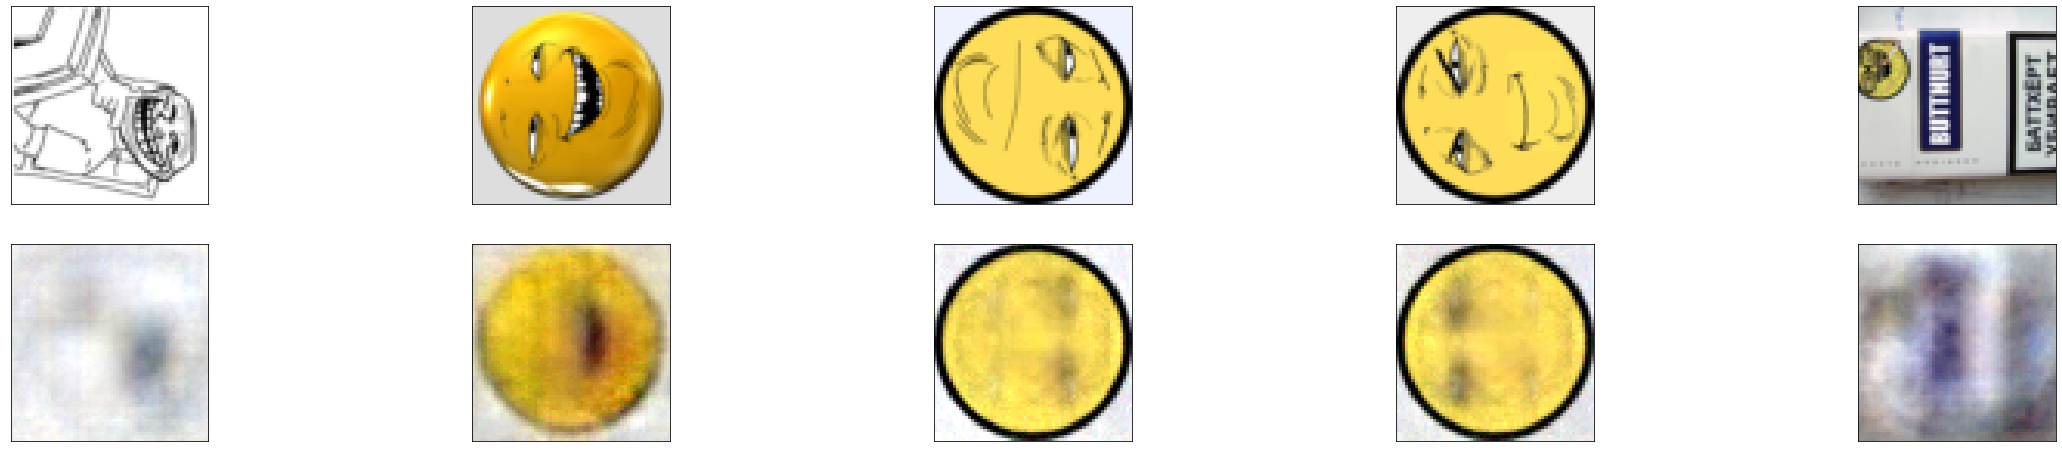

In [950]:
with torch.no_grad():
    test_examples = None
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 3, 64, 64)
        reconstruction = model(test_examples.cuda())
        break
    number = 5
    plt.figure(figsize=(40, 8))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().reshape(3, 64 ,64).T.numpy())
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().reshape(3, 64 ,64).T.numpy())
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [951]:
test_examples[index].numpy().reshape(64, 64, 3).shape

(64, 64, 3)

In [952]:
with torch.no_grad():
    out = model(torch.from_numpy(np.zeros((1, 3, 64, 64), dtype="float32")).cuda())

In [953]:
(np.random.rand(1, 12288).reshape(64, 64, 3).shape), (out.cpu().numpy().reshape(64, 64, 3).shape)

((64, 64, 3), (64, 64, 3))

In [954]:
np.random.rand(1, 48).shape

(1, 48)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


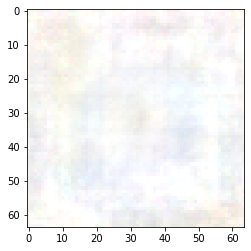

In [955]:
with torch.no_grad():
    out = model(torch.from_numpy(np.ones((1, 3, 64, 64), dtype="float32")).cuda())
    #image = out.cpu().reshape(3, 64 ,64).T
    plt.imshow(out.cpu().reshape(3, 64 ,64).T.numpy())
    #plt.gray()    

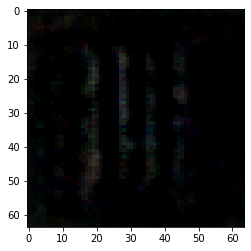

In [956]:
with torch.no_grad():
    image = model(torch.from_numpy(np.zeros((1, 3, 64, 64), dtype="float32")).cuda())
    image = image.cpu()
    image = image.reshape(3, 64 ,64).T
    plt.imshow(image.numpy(), interpolation='nearest')

In [957]:
print(model)

AE(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(384, 192, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): ConvTranspose2d(192, 64, kernel_size=(5, 5), stride=(2, 2))
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), output_padding=(1, 1))
    (13): ReLU()
  )
)


In [959]:
transfer_model = models.AlexNet()
#models.
model = transfer_model.to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [960]:
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25